In [26]:
import pandas as pd
import os
import re
import json
import pandas as pd
import parsedatetime
from datetime import datetime
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates


In [27]:
# Step 1: Locate and load config.json from one level up
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
config_path = os.path.normpath(os.path.join(parent_dir, 'config.json'))

with open(config_path, 'r', encoding='utf-8') as f:
    config = json.load(f)

# Step 2: Build absolute path prefix based on where config.json was loaded from
config_dir = os.path.dirname(config_path)

In [28]:
#  ATTACK group file paths
group_paths = [
    os.path.normpath(os.path.join(config_dir, config["data_directory"], config["file_paths_groups_v15"]["enterprise"])),
    os.path.normpath(os.path.join(config_dir, config["data_directory"], config["file_paths_groups_v15"]["mobile"])),
    os.path.normpath(os.path.join(config_dir, config["data_directory"], config["file_paths_groups_v15"]["ics"]))
]

In [29]:
def extract_dates_from_citations(df):
    # Initialize a dictionary to store the results
    url_date_dict = {}
    cal = parsedatetime.Calendar()

    # Iterate through the rows of the dataframe
    for index, row in df.iterrows():
        url = row['url']
        citation = row['citation']

        # Use parsedatetime to extract date from the citation
        parsed_date, _ = cal.parse(citation)

        if parsed_date:
            # Format the date as YYYY-MM-DD
            extracted_date = datetime(*parsed_date[:6]).date()
            url_date_dict[url] = {'date': extracted_date, 'download_sha256': None}  # Initialize with empty download_sha256
        else:
            url_date_dict[url] = {'date': None, 'download_sha256': None}  # If no date is found, set date as None

    return url_date_dict


def add_sha256_from_jsonl(jsonl_file_path, url_date_dict):
    # Open and read the JSONL file
    try:
        with open(jsonl_file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                url = entry.get('url')
                download_sha256 = entry.get('download_sha256')

                if url in url_date_dict:
                    # Add download_sha256 to the existing entry in url_date_dict
                    url_date_dict[url]['download_sha256'] = download_sha256
    except Exception as e:
        print(f"An error occurred while reading the JSONL file: {e}")



In [30]:
# Read and extract from all group files
url_date_dict = {}

for file_path in group_paths:
    try:
        df = pd.read_excel(file_path, sheet_name='citations')[['url', 'citation']].dropna()
        result = extract_dates_from_citations(df)
        url_date_dict.update(result)
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")

# all_url_dates now contains the combined result
print(f"Total URLs with extracted dates: {len(url_date_dict)}")

Total URLs with extracted dates: 930


In [31]:
mitre_enterprise_jsonl = os.path.normpath(os.path.join(config_dir, config["jsonl_files"]["MITRE_enterprise"]))

# Add the download_sha256 from the JSONL file to the dictionary
add_sha256_from_jsonl(mitre_enterprise_jsonl, url_date_dict)

# Print the modified dictionary
print(len(url_date_dict))

930


In [32]:
def count_unique_ttps_in_file(file_path):
    """
    Extract unique TTPs from a single IOC file using regex.
    Returns the count of unique TTPs found in the file.
    """
    ttp_pattern = re.compile(r'\bT\d{4}(?:\.\d+)?\b')  # Regex to capture TTP IDs
    ttp_set = set()  # To store unique TTPs

    # Verify the file exists
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")  # Debugging message
        return 0  # Return 0 if the file does not exist

    # Open and read the IOC file
    with open(file_path, 'r') as file:
        for line in file:
            matches = ttp_pattern.findall(line)  # Find all TTPs in the line
            ttp_set.update(matches)  # Add found TTPs to the set

    # Return the count of unique TTPs
    return len(ttp_set)

def update_url_date_dict_with_ttp_count(url_date_dict, folder_path):
    """
    Updates the url_date_dict by adding the TTP count for each URL.
    If the corresponding IOC file is not found, sets the TTP count to None.
    """
    # Iterate through the URL dictionary
    for url, data in url_date_dict.items():
        download_sha256 = data.get('download_sha256')

        if download_sha256:
            # Construct the corresponding IOC file name with '.download.iocs' extension
            iocs_file_path = os.path.join(folder_path, f"{download_sha256}.download.iocs")

            # Debugging: Print the path being checked
            #print(f"Checking for IOC file: {iocs_file_path}")

            # Check if the IOC file exists
            if os.path.isfile(iocs_file_path):
                # If the IOC file exists, count the TTPs in the file
                ttp_count = count_unique_ttps_in_file(iocs_file_path)
                #print(ttp_count)
                url_date_dict[url].update({"ttp_count": ttp_count})
            else:
                # If the IOC file doesn't exist, set the TTP count to None
                #print(f"IOC file not found for URL {url}: {iocs_file_path}")  # Debug print for missing files
                url_date_dict[url].update({"ttp_count": None})

    return url_date_dict


In [33]:
mitre_ttp_path = os.path.normpath(os.path.join(config_dir, config["directory_paths_ioc"]["TTP_MITRE"])) 


# Update the URL date dictionary with TTP counts
updated_url_date_dict = update_url_date_dict_with_ttp_count(url_date_dict, mitre_ttp_path)
print(len(updated_url_date_dict))
# You can now work with updated_url_date_dict as needed.


930


In [34]:
# Extract elements where ttp_count is not None, checking if the key exists
filtered_url_date_dict = {url: data for url, data in updated_url_date_dict.items() if data.get('ttp_count') is not None}

# Print the filtered dictionary (optional)
print(len(filtered_url_date_dict))


105


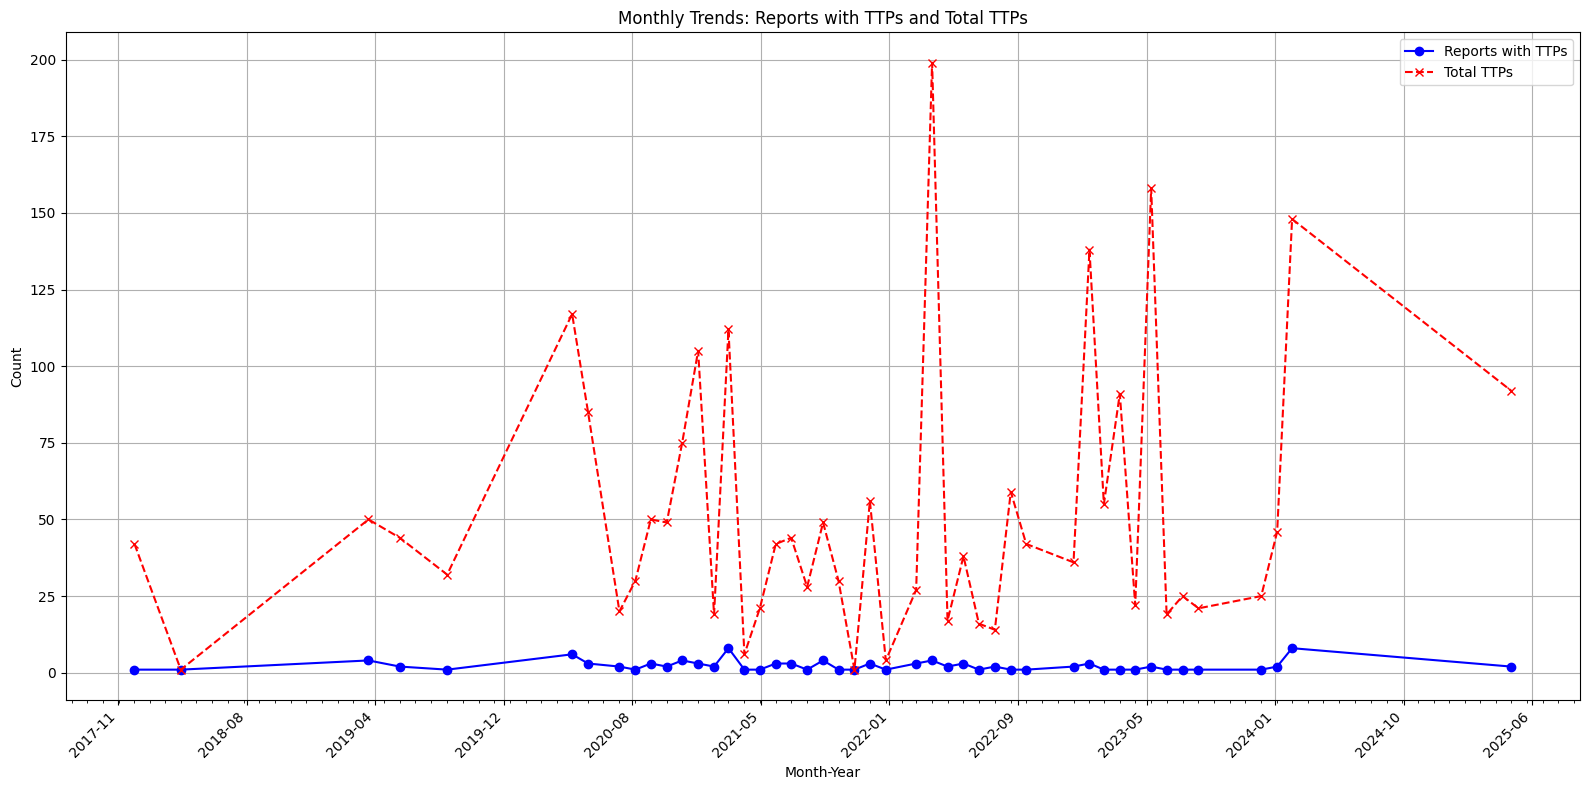

In [35]:
# Step 1: Prepare the data for plotting
monthly_data = defaultdict(lambda: {'report_count': 0, 'ttp_count': 0})

# Aggregate data by month
for url, data in filtered_url_date_dict.items():
    report_date = data['date']
    ttp_count = data['ttp_count']
    
    # Use the first day of the month as the key
    month_key = report_date.replace(day=1)
    
    monthly_data[month_key]['report_count'] += 1
    monthly_data[month_key]['ttp_count'] += ttp_count

# Step 2: Prepare data for plotting
months = sorted(monthly_data.keys())  # Get sorted months (x-axis)
report_counts = [monthly_data[month]['report_count'] for month in months]
ttp_counts = [monthly_data[month]['ttp_count'] for month in months]

# Step 3: Plot the data
plt.figure(figsize=(16, 8))

# Plot line for number of reports (with markers)
plt.plot(months, report_counts, marker='o', linestyle='-', color='b', label="Reports with TTPs")

# Plot line for total TTPs per month (with different marker and line style)
plt.plot(months, ttp_counts, marker='x', linestyle='--', color='r', label="Total TTPs")

# Customize the x-axis with months formatted as 'YYYY-MM'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Place ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as Year-Month
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Add minor ticks for better spacing

# Set the x-axis to show fewer labels to avoid squeezing
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=12))  # Limit to 12 ticks to spread them evenly

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Labels and title
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.title('Monthly Trends: Reports with TTPs and Total TTPs')

# Add grid, legends, and adjust layout
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
